# Deep Learning &mdash; Assignment 12

Twelfth assignment for the 2024 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:** Andrew Schroeder and Fynn Gerding

**Group:** 17

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a diffusion model
2. Extend the model to a class-conditional version

## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch,

All libraries can be installed with `pip install`.

In [1]:
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from IPython import display

# fix the seed, so outputs are exactly reproducible
torch.manual_seed(12345);

# Use the GPU if available
def detect_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
device = detect_device()

## 12.1 MNIST dataset

In this assignment we will once again be using the MNIST digit dataset. This dataset consists of 28×28 binary images and has 60000 training examples divided over 10 classes. We split this into 55000 images for training and 5000 images for validation.

As preprocessing, we pad the images to 32x32 pixels and scale the intensities to [-1, +1].

**(a) Run the code below to load the MNIST dataset.**

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2),               # pad to 32x32 pixels
    transforms.Normalize(0.5, 0.5),  # normalize to [-1, +1]
])
train_val_data = datasets.MNIST('data', train=True, download=True, transform=transform)
# Split into train and validation set
train_data, val_data = torch.utils.data.random_split(train_val_data, [55000, 5000])
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1000)
data_loaders = {
    'train': train_loader,
    'val':   val_loader,
}

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 900kB/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.65MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## 12.2 Training images (4 points)

We will implement a model from the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf) by Ho et al., 2020.

We reuse some parameter settings from the paper:

In [ ]:
diffusion_steps = 1000
beta = torch.linspace(1e-4, 0.02, diffusion_steps)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# put on device

alpha = alpha.to(device)
alpha_bar = alpha_bar.to(device)
beta = beta.to(device)

Using these settings, we can generate a sequence of noisy images with

$$
\begin{aligned}
\mathbf{x}_t
&= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} & \text{ where } \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I}).
\end{aligned}
$$

There is a closed-form solution to compute $x_t$ directly from $x_0$ (see the paper or [this blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#forward-diffusion-process)):

$$
\begin{aligned}
\mathbf{x}_t &= \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} & \text{ where } \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}).
\end{aligned}
$$

**(a) Implement this closed-form solution in the code below to generate random images.<span style="float:right"> (1 point)</span>**

*Expected output: you should see some images with recognizable shapes and some images with noise.*

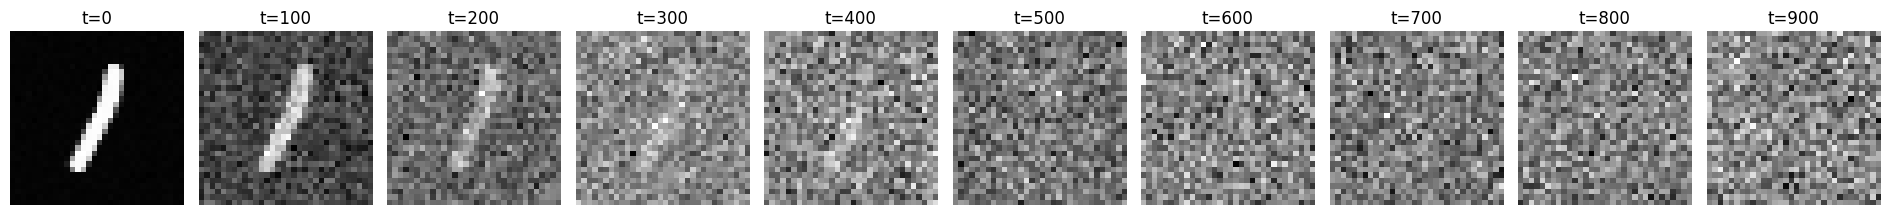

In [4]:
# sample some original images
x_0, y = next(iter(train_loader))

# put on device
x_0 = x_0.to(device)

plt.figure(figsize=(19, 21))
for i, t in enumerate(range(0, diffusion_steps, 100)):
    # TODO generate random noise
    noise = torch.normal(mean=0, std=1, size=x_0.size(), device=device)

    # TODO add noise to the original image to compute x_t
    x_t = torch.sqrt(alpha_bar[t]) * x_0 + torch.sqrt(1 - alpha_bar[t]) * noise

    plt.subplot(3, diffusion_steps // 100, i + 1)
    plt.imshow(x_t[0, 0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f't={t}')
plt.tight_layout()

**(b) Describe how we should interpret these images, and how they can be used to train the diffusion model.<span style="float:right"> (2 points)</span>**

The images show the original imput picture at `t = 0` and then every 100 steps into the diffusion process the image with added noise up to timepoint `t`. In the end, the original image is not visible anymore. By letting the diffusion model learn how an image with certain levels of noise looks like, we allow it to pick up on the added noise. Later, we can use this to reduce the noise of a random starting point one step at a time to get to a newly generated image. Here, it is important that the network sees all in-between steps to understand and reverse the mapping between one state and another, eventually reachin the original image.

During training, we will need a minibatch with multiple images and multiple time steps.

**(c) Complete the function below to add noise to a minibatch of images.<span style="float:right"> (1 point)</span>**

In [5]:
def generate_noisy_samples(x_0, beta):
    '''
    Create noisy samples for the minibatch x_0.
    Return the noisy image, the noise, and the time for each sample.
    '''
    alpha = 1.0 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)

    # sample a random time t for each sample in the minibatch
    t = torch.randint(beta.shape[0], size=(x_0.shape[0],), device=device)
    # TODO generate noise
    noise = torch.normal(mean=0, std=1, size=x_0.size(), device=device)
    # TODO add the noise to each sample
    alpha_bar_t = alpha_bar[t]
    alpha_bar_t = alpha_bar_t.view(-1, 1, 1, 1)
    alpha_bar_t = alpha_bar_t.to(device)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    return x_t, noise, t

**(d) Try out your new function by generating a few noisy samples.**

*Expected output: you should see the samples in the minibatch with different levels of noise, depending on the time $t$ for each sample.*

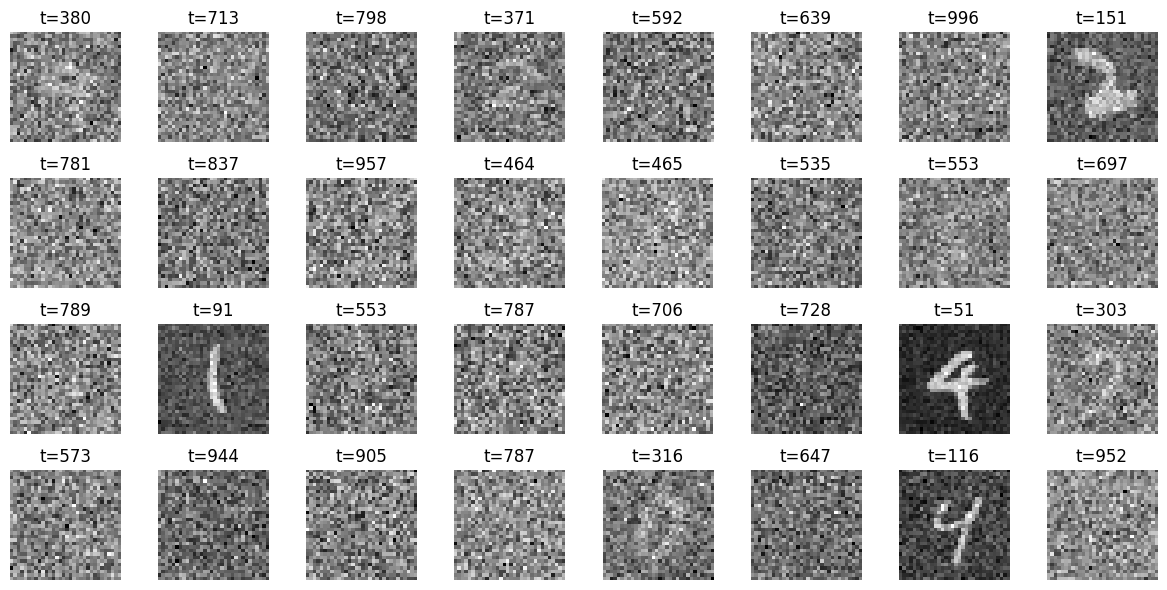

In [6]:
x_0, y = next(iter(train_loader))
x_0 = x_0.to(device)

x_t, noise, sampled_t = generate_noisy_samples(x_0, beta)
assert x_t.shape == x_0.shape
assert noise.shape == x_0.shape
assert sampled_t.shape == (x_0.shape[0],)

plt.figure(figsize=(12, 6))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(x_t[i, 0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f't={sampled_t[i]}')
plt.tight_layout()

## 12.3 Helper functions

We will use some predefined components to construct our model, based on [an existing implementation](https://github.com/dome272/Diffusion-Models-pytorch) on GitHub.

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, h_size):
        super(SelfAttention, self).__init__()
        self.h_size = h_size
        self.mha = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )

    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value

class SAWrapper(nn.Module):
    def __init__(self, h_size, num_s):
        super(SAWrapper, self).__init__()
        self.sa = nn.Sequential(*[SelfAttention(h_size) for _ in range(1)])
        self.num_s = num_s
        self.h_size = h_size

    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s * self.num_s).swapaxes(1, 2)
        x = self.sa(x)
        x = x.swapaxes(2, 1).view(-1, self.h_size, self.num_s, self.num_s)
        return x

# U-Net code adapted from: https://github.com/milesial/Pytorch-UNet

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, in_channels, residual=True)
            self.conv2 = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## 12.4 Diffusion model (5 points)

Similar to Ho et al. and to several online implementations, we will use a U-Net with self-attention and positional embedding as our diffusion model.

**(a) Familiarize yourself with the architecture of this U-Net.**

In [8]:
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, width=16):
        super().__init__()

        self.width = width
        bilinear = True
        self.inc = DoubleConv(c_in, self.width)
        self.down1 = Down(self.width, self.width*2)
        self.down2 = Down(self.width*2, self.width*4)
        factor = 2 if bilinear else 1
        self.down3 = Down(self.width*4, self.width*8 // factor)
        self.up1 = Up(self.width*8, self.width*4 // factor, bilinear)
        self.up2 = Up(self.width*4, self.width*2 // factor, bilinear)
        self.up3 = Up(self.width*2, self.width, bilinear)
        self.outc = OutConv(self.width, c_out)
        self.sa1 = SAWrapper(self.width*4, 8)
        self.sa2 = SAWrapper(self.width*4, 4)
        self.sa3 = SAWrapper(self.width*2, 8)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=t.device).float() / channels)
        )
        pos_enc_a = torch.sin(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        device = x.device
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, self.width*2, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, self.width*4, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, self.width*4, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, self.width*2, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, self.width, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, self.width, 32)
        output = self.outc(x)
        return output

**(b) What does the positional encoding encode? Why would this be useful?<span style="float:right"> (2 points)</span>**

The positional encoding encodes the information about the timestep, so `t`. It does this through a combination of sin and cos waves. This information gives the images a perspective of time and orders the diffusion steps into earlier (more accurate) and later (more random) steps. This allows to meaningfully comunicate sequential informaiton.

This is necessary as the estimation of noise and later reversal of noise depends on which step in the Markov the current image corresponds to. With an understanding of order, the network can learn about the dynamics and learn to make accurate estimations about each stage in this process. This is also required for accurate reconstruction of images - the network needs to know where an image is and where it should go to (less noisy, but how far).

**(c) Describe how this model will be used. What do the inputs and outputs represent?<span style="float:right"> (3 points)</span>**

*Used for:* The network is used to estimate the noise in an image. By learning to extract this, the network implicitly also learns the distributions and will be able to remove noise in the denoising process.

*Inputs:* The image and the positional encoding of the time point.

*Outputs:* The estimated noise in the image; the shape will be identical to the shape of the input image.

## 12.5 Training the model (7 points)

We will train our diffusion model using Algorithm 1 from the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf) by Ho et al., 2020.

**(a) The algorithm uses $\mathbf{x}_0$. How do you obtain $\mathbf{x}_0$ during training?<span style="float:right"> (1 point)</span>**

`x_0` is sampled directly from the training dataset at the beginning of each training step. (Will be an image from the MNIST dataset) It is then used to generate noisy versions and the model can learn to perdict the translation between noise and original samples.

**(b) Which two values are compared in the loss on line 5 of the algorithm?<span style="float:right"> (1 point)</span>**

The true value for $\epsilon$ and the estimated $\epsilon_\theta$. The difference is minimized during training. $\epsilon_\theta$ is estimated given a certain input $x_t$ and then compared with the true $\epsilon$ which is drawn from a normal distrubution $\mathcal{N}(0,1)$.

**(c) Implement this procedure in the training loop below.<span style="float:right"> (3 points)</span>**

In [9]:
def train(model, data_loaders, beta, num_epochs=10, lr=1e-3, device=device):
    """Train a diffusion model"""
    train_loader = data_loaders['train']
    validation_loader = data_loaders['val']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    plotter = Plotter(xlabel='epoch', xlim=[1, num_epochs],
                      legend=['train loss', 'validation loss'])
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        metrics = Metrics(1)
        for x, y in train_loader:
            x = x.to(device)
            optimizer.zero_grad()

            # TODO compute the loss for minibatch x
            # hint: we already have a function to generate noisy images

            x_t, noise, t = generate_noisy_samples(x, beta)

            # TODO compute model output
            y_hat = model(x_t, t)

            # MSE loss between the model output and the true noise
            loss = F.mse_loss(y_hat, noise)

            # Optimize
            loss.backward()
            optimizer.step()

            # Track our progress
            metrics.add(len(x), loss.item())
        train_loss = metrics.mean()[0]

        # Compute validation loss
        validation_loss = evaluate(model, validation_loader, beta, device=device)

        # Plot
        plotter.add(epoch + 1, (train_loss, validation_loss))

    train_time = time.time() - start_time
    print(f'training loss {train_loss:.3g}, validation loss {validation_loss:.3g}')
    print(f'{metrics.count * num_epochs / train_time:.1f} examples/sec '
          f'on {str(device)}')

def evaluate(model, test_loader, beta, device=device):
    """Evaluate a diffusion model by computing the loss."""
    with torch.no_grad():
        model.eval()
        metrics = Metrics(1)
        for x, y in test_loader:
            x = x.to(device)
            x_t, noise, t = generate_noisy_samples(x, beta)
            y_hat = model(x_t, t)
            loss = F.mse_loss(y_hat, noise)
            metrics.add(len(x), loss.item())
    return metrics.mean()[0]

class Metrics:
    """Accumulate mean values of one or more metrics."""
    def __init__(self, n):
        self.count = 0
        self.sum = (0,) * n
    def add(self, count, *values):
        self.count += count
        self.sum = tuple(s + count * v for s,v in zip(self.sum,values))
    def mean(self):
        return tuple(s / self.count for s in self.sum)

class Plotter:
    """For plotting data in animation."""
    # Based on d2l.Animator
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a function to capture arguments
        def config_axes():
            axis = self.axes[0]
            axis.set_xlabel(xlabel), axis.set_ylabel(ylabel)
            axis.set_xscale(xscale), axis.set_yscale(yscale)
            axis.set_xlim(xlim),     axis.set_ylim(ylim)
            if legend:
                axis.legend(legend)
            axis.grid()
        self.config_axes = config_axes
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

**(d) How does the training time depend on the number of diffusion steps $T$?<span style="float:right"> (1 point)</span>**

Since at everys step, only one t is sampled, the computational cost per training step is constant. BUT, this also means that to have a more accurate sample for all values for t more training steps are necessary. So, while the individual step is not dependent on `T`, the amount of necessary steps for a good performance is dependend on it.

**(e) Train the model.**

*Expected output: in our implementation, the training loss started at around 0.1 and went down quickly to 0.03 and lower.*

training loss 0.0198, validation loss 0.0197
1933.5 examples/sec on cuda


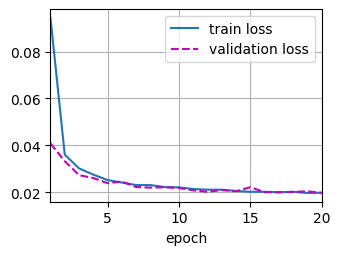

In [10]:
model = UNet().to(device)
train(model, data_loaders, beta, num_epochs=20, lr=1e-3)

**(f) Has the training converged? Do you think we should train longer?<span style="float:right"> (1 point)</span>**

It looks like the model converged quite fast (after about 10 epochs).

## 12.6 Sampling from the model (9 points)

Once the model is trained, we can sample from it using Algorithm 2 from paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf):

**Algorithm 2**:  
1: $\mathbf{x}_T \sim \mathcal{N}(\mathbf 0, \mathbf I)$  
2: for $t = T, \dots, 1$ do  
3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{z} \sim \mathcal{N}(\mathbf 0, \mathbf I)$ if $t > 1$, else $\mathbf{z} = \mathbf{0}$  
4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{x}_{t-1} = \frac{1}{\sqrt{a_t}} \left( \mathbf{x}_t - \frac{1-a_t}{\sqrt{1-\bar{a}_t}} \mathbf{\epsilon}_\theta \left(\mathbf{x}_t, t\right)\right) + \mathbf{\sigma}_t \mathbf{z}$  
5: end for  
6: return $\mathbf{x}_0$

**(a) In step 3 of algorithm 2, $\mathbf{z}$ is set to $\mathbf{0}$ some times. What is the effect of this?<span style="float:right"> (1 point)</span>**

For the last timestep (t=1) z is set to 0 to finish without introducing any further randomness as this will be the final output

**(b) In step 4 of algorithm 2, $\mathbf{x}_{t-1}$ is computed based on three ingredients: $\mathbf{x}_t$, $\mathbf{\epsilon}_\theta \left(\mathbf{x}_t, t\right)$, and $\mathbf{z}$. What do these represent? <span style="float:right"> (2 points)</span>**

* $\mathbf{x}_t$: current (noisy) sample
* $\mathbf{\epsilon}_\theta \left(\mathbf{x}_t, t\right)$: Estimated noise added at time point $t$
* $\mathbf{z}$: Normally distributed noise added for stochasticity

**(c) How does the sampling time depend on the number of diffusion steps $T$?<span style="float:right"> (1 point)</span>**

As the denoising process has to reverse every step in $T$, it is linearly related to the amount of steps in the noising process.

**(d) Complete the code below to sample a minibatch from the model.<span style="float:right"> (2 points)</span>**

* Use the equations in Algorithm 2.
* Use $\sigma_t = \sqrt{\beta_t}$, as suggested in the paper.
* Keep in mind that Algorithm 2 uses $t=1$ as the first time step, whereas we use $t=0$.

*Expected output: after training, your model should generate fairly realistic, clean images when given random inputs.*

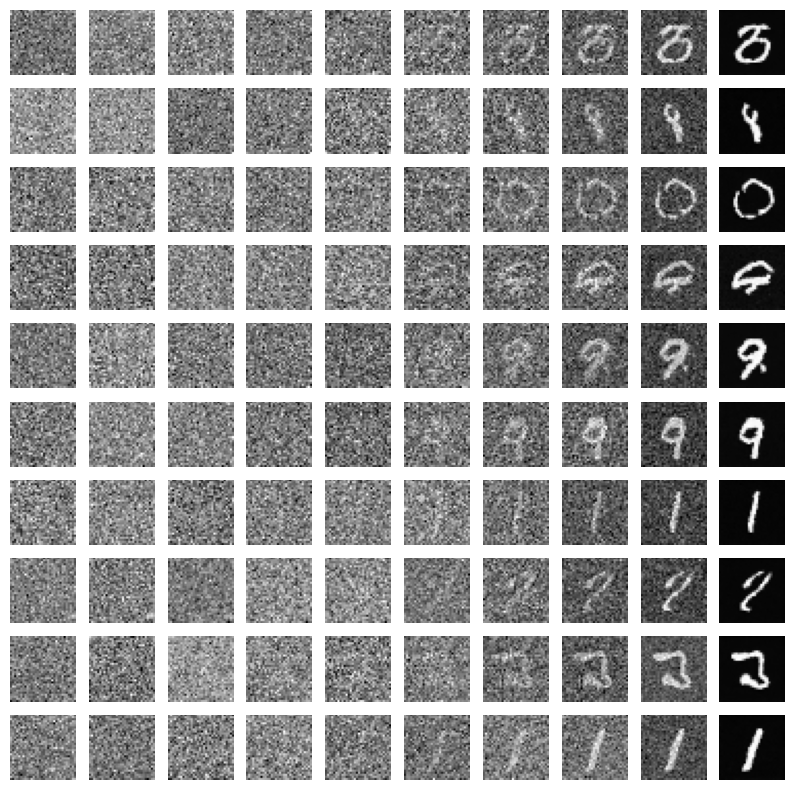

In [11]:
def sample_from_model(x, model, beta, device=device):
    # keep track of x at different time steps
    x_hist = []
    alpha = 1.0 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    with torch.no_grad():
        # loop over all time steps in reverse order
        for i in reversed(range(0, beta.shape[0])):
            # copy the time step for each sample in the minibatch
            t = (torch.ones(x.shape[0]) * i).long().to(device)
            # TODO compute the next value of x
            epsilon_theta = model(x, t)
            if i > 0:
                sigma_t = torch.sqrt(beta[i])
                z = torch.randn_like(x)
            else:
                sigma_t = 0.0
                z = 0.0
            x = (1 /  torch.sqrt(alpha[i])) * (x - (1 - alpha[i]) / torch.sqrt(1 - alpha_bar[i]) * epsilon_theta) + sigma_t * z
            if i % 100 == 0:
                x_hist.append(x.detach().cpu().numpy())
    return x, x_hist

def plot_x_hist(x_hist):
    # plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(len(x_hist)):
        for j in range(10):
            plt.subplot(10, 10, j * 10 + i + 1)
            plt.imshow(x_hist[i][j, 0], cmap='gray')
            plt.axis('off')


# TODO initialize x with the right values
# shape: [10, 1, 32, 32]

# Normally distributed start image
x = torch.randn(10, 1, 32, 32).to(device)

x, x_hist = sample_from_model(x, model, beta)
plot_x_hist(x_hist)

**(e) Explain the X and Y axes of this figure.<span style="float:right"> (1 point)</span>**

We started with 10 randomly genrated noisy images that are stacked on the left of the image. The y axis therefore corresponds to indiviudal denoising processes. The x axis shows 10 steps of denoising these images: from left to right the network removes noise with every step until the final image is reached that looks something like a number...

**(f) In a variational autoencoder or a GAN, the output is determined by the latent representation. How does that work for this diffusion model?<span style="float:right"> (1 point)</span>**

In diffusion models, the output is not predetermined by the latent representation, but by the iterative refinement of noisy images. Therefore, the model itself is determining the output.

**(g) Look at the generated intermediate samples over time in question (d). Do we need all of the steps? Why/why not?<span style="float:right"> (1 point)</span>**

The denoising process gradually transforms the initial random input. The stepwise refinement is a tradeoff between quality and speed: Less steps might be sufficient but lead to worse results.

## 12.7 Experiments (5 points)

### Fixed initialization

How does the end result depend on the initialization? We will generate multiple images from the same initial noise to find out.

**(a) Complete and run the code below.</span>**

*Expected output: the model should still produce recognizable shapes.*

torch.Size([1, 1, 32, 32])


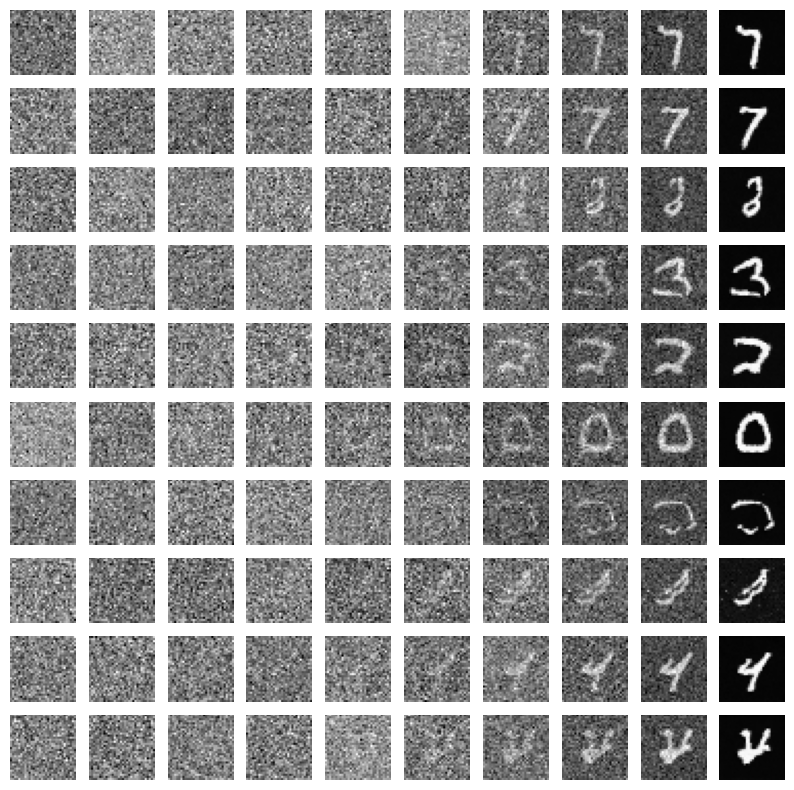

In [20]:
# TODO initialize x=x_T with the right values for one image
# (see earlier question)
# shape: [1, 1, 32, 32]
#x = torch.zeros_like(x_0[:1]).to(device) # TODO: change
x = torch.randn(1, 1, 32, 32).to(device)
print(x.shape)
# repeat this to generate 10 images from the same initialization
x = x.repeat(10, 1, 1, 1)

x, x_hist = sample_from_model(x, model, beta)
plot_x_hist(x_hist)

**(b) Does the model always produce the same output from the same initial input? Why, or why not?<span style="float:right"> (2 points)</span>**

No, the model would not always produce the same output from the latent space. If we were to condition on a single digit then it would produce variations on this digit. We can see in lines three and four that each timestep t is dependent on a randomly distributed variable $Z$, thus even though we start with the same initial state, the $Z$ variable introduces randomness to the outputs.

3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{z} \sim \mathcal{N}(\mathbf 0, \mathbf I)$ if $t > 1$, else $\mathbf{z} = \mathbf{0}$  
4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{x}_{t-1} = \frac{1}{\sqrt{a_t}} \left( \mathbf{x}_t - \frac{1-a_t}{\sqrt{1-\bar{a}_t}} \mathbf{\epsilon}_\theta \left(\mathbf{x}_t, t\right)\right) + \mathbf{\sigma}_t \mathbf{z}$  

### No randomness between time steps

To check the influence of noise during sampling, we can remove the term $\sigma_t \mathbf{z}$ from Algorithm 2.

**(c) Create a new function `deterministic_sample_from_model`, based on `sample_from_model`, that does not include this term.<span style="float:right"> (2 points)</span>**

In [16]:
def deterministic_sample_from_model(x, model, beta, device=device):

    # keep track of x at different time steps
    x_hist = []
    alpha = 1.0 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    with torch.no_grad():
        # loop over all time steps in reverse order
        for i in reversed(range(0, beta.shape[0])):
            # copy the time step for each sample in the minibatch
            t = (torch.ones(x.shape[0]) * i).long().to(device)
            # TODO compute the next value of x
            epsilon_theta = model(x, t)

            x = (1 /  torch.sqrt(alpha[i])) * (x - (1 - alpha[i]) / torch.sqrt(1 - alpha_bar[i]) * epsilon_theta)
            if i % 100 == 0:
                x_hist.append(x.detach().cpu().numpy())
    return x, x_hist

**(d) Generate some samples using the new function.**

*Expected output: you should get a different result than before.*

torch.Size([10, 1, 32, 32])


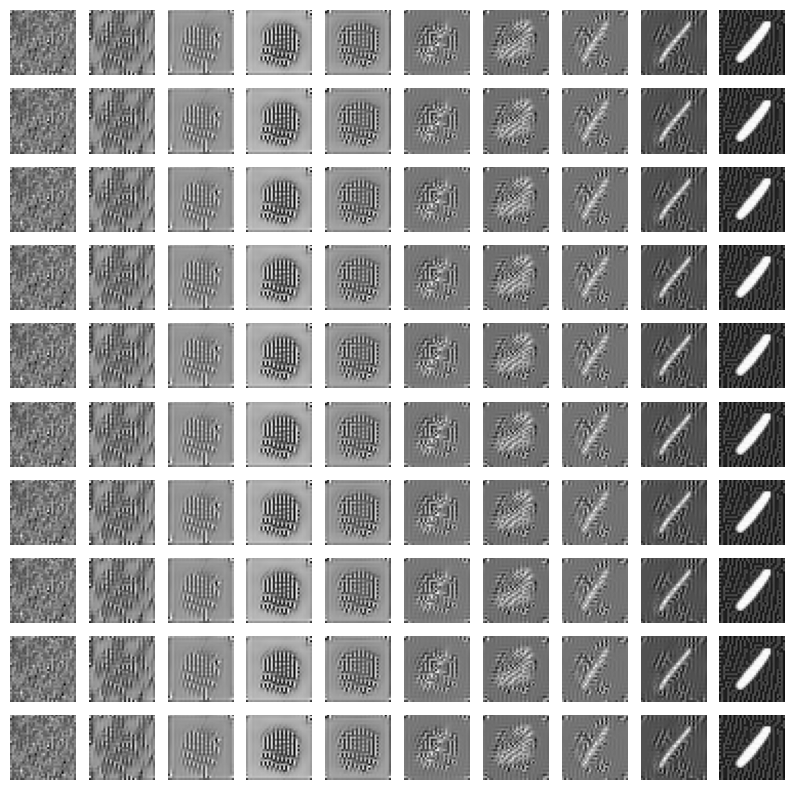

In [ ]:
# TODO initialize x with the right values
# (see earlier questions)
# shape: [10, 1, 32, 32]
#x = torch.zeros_like(x_0[:10]).to(device)

x = torch.randn(1, 1 , 32, 32).to(device)
x = x.repeat(10, 1, 1, 1)
print(x.shape)

x, x_hist = deterministic_sample_from_model(x, model, beta)
plot_x_hist(x_hist)

**(e) What can you conclude from these results? Is the random noise during sampling important?<span style="float:right"> (1 point)</span>**

Yes the random noise is important so that we don't get deterministic results that are always the same.

## 12.8 Making the model conditional (6 points)

Similar to the conditional VAE in the previous assignment, we can make the diffusion model conditional by including class labels. This allows us to generate samples from a specific digit.

We will include the class information alongside the existing positional encoding, using a [`torch.nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) layer to map the 10 digits to a higher-dimensional space.

### Conditional model

**(a) Study the implemenation of UNetConditional to see how this works.**

In [23]:
class UNetConditional(nn.Module):
    def __init__(self, c_in=1, c_out=1, n_classes=10, width=16):
        super().__init__()

        self.width = width
        bilinear = True
        self.inc = DoubleConv(c_in, self.width)
        self.down1 = Down(self.width, self.width*2)
        self.down2 = Down(self.width*2, self.width*4)
        factor = 2 if bilinear else 1
        self.down3 = Down(self.width*4, self.width*8 // factor)
        self.up1 = Up(self.width*8, self.width*4 // factor, bilinear)
        self.up2 = Up(self.width*4, self.width*2 // factor, bilinear)
        self.up3 = Up(self.width*2, self.width, bilinear)
        self.outc = OutConv(self.width, c_out)
        self.sa1 = SAWrapper(self.width*4, 8)
        self.sa2 = SAWrapper(self.width*4, 4)
        self.sa3 = SAWrapper(self.width*2, 8)

        self.label_embedding = nn.Embedding(n_classes, self.width*4)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=t.device).float() / channels)
        )
        pos_enc_a = torch.sin(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def label_encoding(self, label, channels, embed_size):
        return self.label_embedding(label)[:, :channels, None, None].repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t, label):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, self.width*2, 16) + self.label_encoding(label, self.width*2, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, self.width*4, 8) + self.label_encoding(label, self.width*4, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, self.width*4, 4) + self.label_encoding(label, self.width*4, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, self.width*2, 8) + self.label_encoding(label, self.width*2, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, self.width, 16) + self.label_encoding(label, self.width, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, self.width, 32) + self.label_encoding(label, self.width, 32)
        output = self.outc(x)
        return output

**(b) As in [the paper by Ho et al.](https://arxiv.org/pdf/2006.11239.pdf), the position and label encoding are added in every layer of the model, instead of as an input to the first layer only. Why do you think the authors made this choice?<span style="float:right"> (1 point)</span>**

Encoding the labeles and the positions at every layer reinforces the signal at every step of the u-net network, preventing the signal from degrading across layers as the input is downsampled and upsampled.

### Conditional training loop

**(c) Create a new function `train_conditional` to train this model.<span style="float:right"> (1 point)</span>**

In [ ]:
def train_conditional(model, data_loaders, beta, num_epochs=10, lr=1e-3, device=device):
    """Train a diffusion model"""
    train_loader = data_loaders['train']
    validation_loader = data_loaders['val']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    plotter = Plotter(xlabel='epoch', xlim=[1, num_epochs],
                      legend=['train loss', 'validation loss'])
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        metrics = Metrics(1)
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            # TODO compute the loss for minibatch x
            # hint: we already have a function to generate noisy images

            x_t, noise, t = generate_noisy_samples(x, beta)

            # TODO compute model output
            y_hat = model(x_t, t, y)

            # MSE loss between the model output and the true noise
            loss = F.mse_loss(y_hat, noise)

            # Optimize
            loss.backward()
            optimizer.step()

            # Track our progress
            metrics.add(len(x), loss.item())
        train_loss = metrics.mean()[0]

        # Compute validation loss
        validation_loss = evaluate(model, validation_loader, beta, device=device)

        # Plot
        plotter.add(epoch + 1, (train_loss, validation_loss))TODO

    train_time = time.time() - start_time
    print(f'training loss {train_loss:.3g}, validation loss {validation_loss:.3g}')
    print(f'{metrics.count * num_epochs / train_time:.1f} examples/sec '
          f'on {str(device)}')

def evaluate(model, test_loader, beta, device=device):
    """Evaluate a diffusion model by computing the loss."""
    with torch.no_grad():
        model.eval()
        metrics = Metrics(1)
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            x_t, noise, t = generate_noisy_samples(x, beta)
            y_hat = model(x_t, t, y)
            loss = F.mse_loss(y_hat, noise)
            metrics.add(len(x), loss.item())
    return metrics.mean()[0]

**(d) Train the conditional model.**

*Expected output: in our implementation, the training loss started at around 0.1 and went down quickly to 0.03 and lower.*

training loss 0.0197, validation loss 0.019
1873.0 examples/sec on cuda


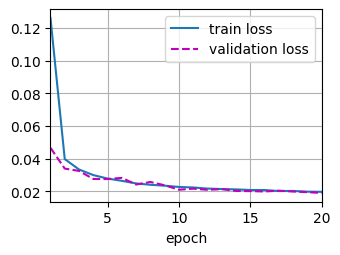

In [25]:
model_conditional = UNetConditional().to(device)
train_conditional(model_conditional, data_loaders, beta, num_epochs=20, lr=1e-3)

### Conditional sampling

**(e) Modify the sampling function to include a label.<span style="float:right"> (1 point)</span>**

In [32]:
def sample_from_model_conditional(x, model, beta, label, device=device):
    # keep track of x at different time steps
    x_hist = []
    alpha = 1.0 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    with torch.no_grad():
        # loop over all time steps in reverse order
        for i in reversed(range(0, beta.shape[0])):
            # copy the time step for each sample in the minibatch
            t = (torch.ones(x.shape[0]) * i).long().to(device)
            # TODO compute the next value of x
            epsilon_theta = model(x, t, label)
            if i > 0:
                sigma_t = torch.sqrt(beta[i])
                z = torch.randn_like(x)
            else:
                sigma_t = 0.0
                z = 0.0
            x = (1 /  torch.sqrt(alpha[i])) * (x - (1 - alpha[i]) / torch.sqrt(1 - alpha_bar[i]) * epsilon_theta) + sigma_t * z
            if i % 100 == 0:
                x_hist.append(x.detach().cpu().numpy())
    return x, x_hist

**(f) Sample a few digits with label `3`.<span style="float:right"> (1 point)</span>**

*Expected output: you should see recognizable images with the number you requested.*

torch.Size([10, 1, 32, 32])
torch.Size([10])


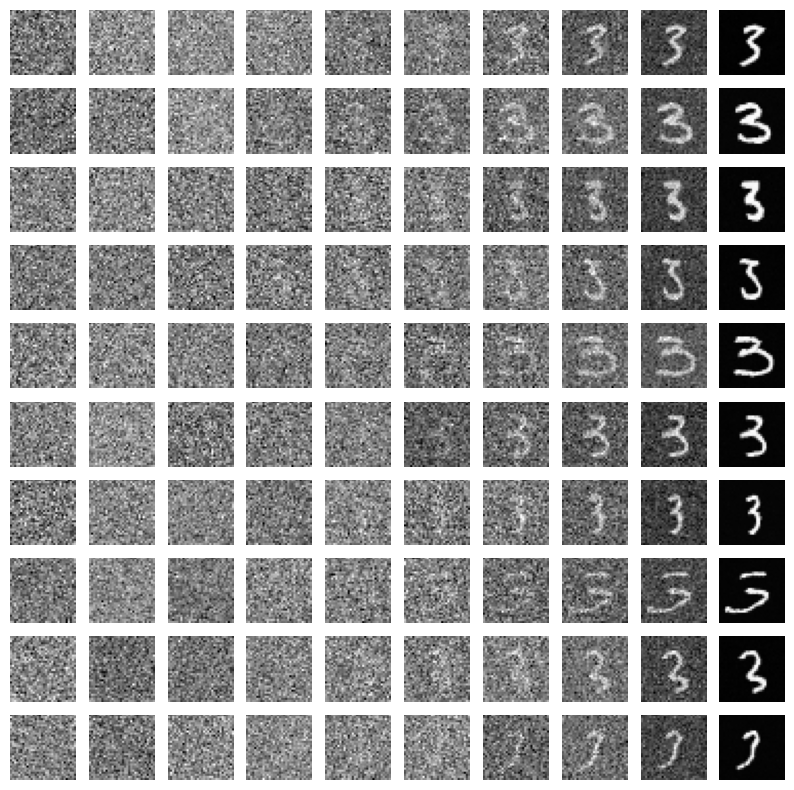

In [41]:
x = torch.randn(1, 1 , 32, 32).to(device)
x = x.repeat(10, 1, 1, 1)
print(x.shape)
label = torch.tensor(3).repeat(10).to(device)
print(label.shape)

x, x_hist = sample_from_model_conditional(x, model_conditional, beta, label)
plot_x_hist(x_hist)


**(g) Complete the code to sample and plot 10 samples for every digit.<span style="float:right"> (1 point)</span>**

In [ ]:
x_per_class = []
for label in range(10):
    # sample 10 digits with this label
    x = torch.randn(1, 1 , 32, 32).to(device)$$

    x = x.repeat(10, 1, 1, 1)
    label = torch.tensor(label).repeat(10).to(device)

    x, x_hist = sample_from_model_conditional(x, model_conditional, beta, label)
    x_per_class.append(x.detach().cpu().numpy())

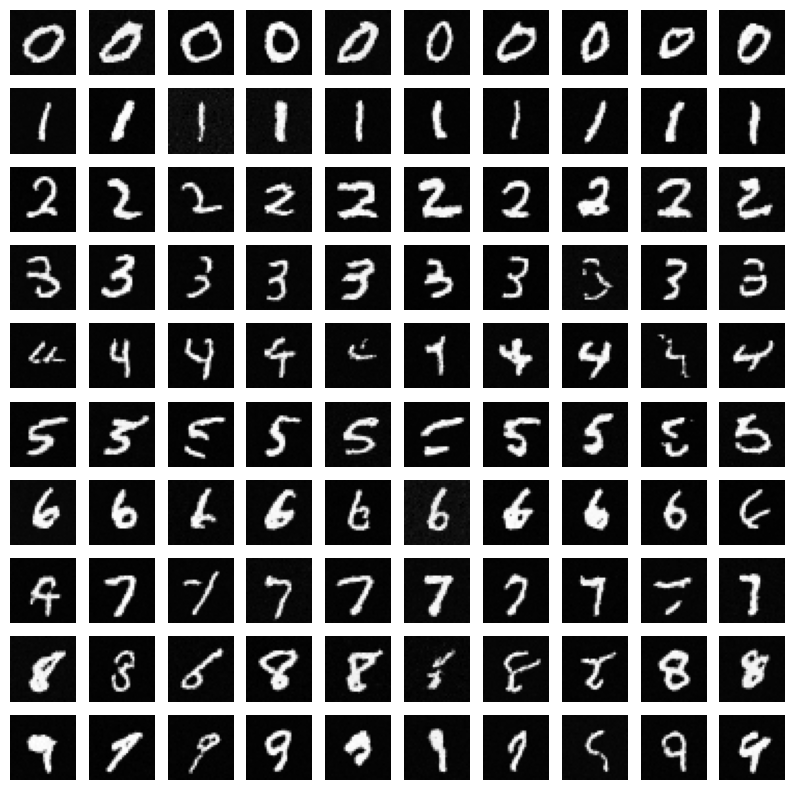

In [45]:
plt.figure(figsize=(10, 10))
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, j * 10 + i + 1)
        plt.imshow(x_per_class[j][i, 0], cmap='gray')
        plt.axis('off')

**(h) Compare the output of the conditional model with that of the unconditional model. Which one is better?<span style="float:right"> (1 point)</span>**

The conditional model seems to perform better because it has the additional information about what label to make. The unconditional model seems to make some pretty sloppy digits, thought they are mostly still interpretable. 

## 12.9 Discussion (6 points)

**(a) Compare the sources of randomness in our diffusion model with that in the variational autoencoder and the GAN in earlier assignments. What are the main differences?<span style="float:right"> (1 point)</span>**

The random noise for diffusion models is very similar to that of GANs where neither of them encode feature representations of the data. They both essentially start with a noraml distribution as a "seed" for generating images, while the VAE's actually use a compressed latent space, where the "noise" is a lower dimension than the data space and hence has compressed features. In VAE's and Diffusion also both use the reparameterization trick to learn the mean of a normal distribution, and then use a separate epsilon to introduce randomness in order to allow gradients to flow. In VAE's the latent space z is learned. Another difference between GANs and VAE's is that GANs only sample noise at the beginning, while diffusion samples noise at each step during decoding.

**(b) Would you be able to train a good digit classification model on the initial input to the sampling function? Why, or why not?<span style="float:right"> (1 point)</span>**

Hint: for variational autoencoders, normalzing flows, and GANs, there is a clear link between the input (a latent feature vector) and the output of the decoder. How does this work for our diffusion model?

No you would not be able to train a good classfication model on the initial input to the sampling function. The initial input is just normaly distributed noise and there is no features or learned representations in this noise, thus you could not use it for classification.

**(c) When loading the data, we normalized the image intensities to [-1, +1], instead of [0, 1] or [0, 255]. Why is this a good input range for this diffusion model?<span style="float:right"> (1 point)</span>**

Because we are working with normal distributions during the encoding and decoding phase, using image intensities centered around zero and symmetric make sense because normal distribution is also centered around 0. This likely leads to more stable training.

**(d) In this assignment, we use a $\beta$ schedule that has a small $\beta=1e-4$ at the initial time steps ($t=0$), and a larger $\beta=0.02$ at the end ($t=T$). Why is it useful to choose an increasing $\beta$?<span style="float:right"> (1 point)</span>**


It makes sense to use increasing beta because at the beginning we want to have a relatively strong signal from the image data and relatively small steps in noise, as this is where the most detail is. Later when the details have been lost due to the noise, we can take larger steps, reducing the signal from the original image quicker and adding more noise to speed up convergence. Then during sampling we can again remove noise in large chunks at the beginning, but then more slowly near the end, to not overshoot the final input.

**(e) What would happen if we made $\beta$ very small?<span style="float:right"> (1 point)</span>**

If beta was very small at the beginning then training could take a long time to converge as we are only adding a small amount of noise at each step, so getting to the prior normal distribution would not be quick. Additionally, sampling would take a long time since we would have to go through many more small denoising steps to get the original data back.

**(f) What would happen if we made $\beta$ very large?<span style="float:right"> (1 point)</span>**

If beta was very large the model would like have difficulty learning the noise and would struggle during sampling and would likely produce very poor images what were still corrupted with noise.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 42 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 70d23d4 / 2024-12-03</span>